In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from models.microstruc_laststep_GINOT import LoadModel
from models import configs
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
import pyvista as pv
import json
from IPython.display import HTML, display_html
device = "cuda" if torch.cuda.is_available() else "cpu"



In [2]:
# pv.set_jupyter_backend('html')
pv.set_jupyter_backend('static')
# pv.set_jupyter_backend('client')
# pv.global_theme.trame.jupyter_extension_enabled = True
# pv.global_theme.trame.server_proxy_enabled = True


In [3]:
configs_load = configs.microstruc_GINOT_configs()

filebase = configs_load["filebase"]
trunk_args = configs_load["trunk_args"]
branch_args = configs_load["branch_args"]
ginot = LoadModel(filebase, branch_args, trunk_args)
print("filebase: ", filebase)
print("trunk_args: ", trunk_args)
print("branch_args: ", branch_args)


Total number of parameters of Geo encoder: 1083136, 1083136 of which are trainable
Total number of parameters of NTO model: 2502403, 2502403 of which are trainable
filebase:  /work/hdd/bdsy/qibang/repository_Wbdsy/GINOT/models/saved_weights/microstruc_laststep_GINOT
trunk_args:  {'embed_dim': 128, 'cross_attn_layers': 4, 'num_heads': 8, 'dropout': 0.0, 'padding_value': -1000}
branch_args:  {'input_channels': 2, 'out_c': 128, 'latent_d': None, 'width': 128, 'n_point': 128, 'n_sample': 8, 'radius': 0.2, 'd_hidden': [128, 128], 'num_heads': 4, 'cross_attn_layers': 2, 'self_attn_layers': 2, 'fps_method': 'fps', 'pc_padding_val': -1000, 'dropout': 0.0}


In [4]:
_, test_dataloader, cells10k, su_inverse = configs.LoadDataMicroSturcGeo(
    bs_train=64, bs_test=128)


In [5]:


def predict(data_loader, ginot):
    y_pred = []
    y_true = []
    verts_all = []
    pc_all = []
    sample_ids = np.empty(0, dtype=int)
    ginot.eval()
    with torch.no_grad():
        for data in tqdm(data_loader, desc="Predicting"):
            pc = data[0].to(device)  # (B, N, 2)
            xyt = data[1].to(device)  # (B, N, 2)
            y_true_batch = data[2].to(device)  # (B, N)
            mask = (y_true_batch != ginot.padding_value)
            pred = ginot(xyt, pc)
            pred = su_inverse(pred)
            y_true_batch = su_inverse(y_true_batch)
            pred = [x[i].view(-1, *i.shape[1:]).cpu().detach().numpy()
                    for x, i in zip(pred, mask)]
            y_true_batch = [x[i].view(-1, *i.shape[1:]).cpu().detach().numpy()
                            for x, i in zip(y_true_batch, mask)]
            y_pred = y_pred+pred
            y_true = y_true+y_true_batch

            mask_verts = (xyt != configs.PADDING_VALUE).cpu().detach().numpy()
            verts_all = verts_all+[x[i].view(-1, *i.shape[1:]).cpu().detach().numpy()
                                   for x, i in zip(xyt, mask_verts)]
            pc_all = pc_all+[x.cpu().detach() for x in pc]
            sample_ids = np.append(sample_ids, data[3].cpu().detach().numpy())

    return y_pred, y_true, verts_all, pc_all, sample_ids


def get_pvstyle_cells(cells_np):
    """cells_np is a numpy array of shape (N, 4)"""
    cell_types = np.zeros(len(cells_np), dtype=int)
    cells = np.empty((0,), dtype=int)
    for i, c in enumerate(cells_np):
        c = c-1  # abaqus uses 1-based index
        if c[-1] == c[-2]:
            cell_types[i] = pv.CellType.TRIANGLE
            cells = np.append(cells, np.array([3, *(c[:-1])]))
        else:
            cell_types[i] = pv.CellType.QUAD
            cells = np.append(cells, np.array([4, *c]))
    return cells, cell_types


def plot_results(pc, su_true, su_pred, cells_np, verts,
                 label="Mises stress [MPa]", opacity=1.0,
                 cmap="viridis", pc_color='green', point_size=8.0,
                 notebook=None, show_edges=True,
                 html_file=None, window_size=(1024, 256)):
    cells, cell_types = get_pvstyle_cells(cells_np)
    defomred_verts_t = verts + su_true[:, 1:3]
    defomred_verts_p = verts + su_pred[:, 1:3]
    defomred_verts_t = np.hstack(
        (defomred_verts_t, np.zeros((defomred_verts_t.shape[0], 1))))
    defomred_verts_p = np.hstack(
        (defomred_verts_p, np.zeros((defomred_verts_p.shape[0], 1))))
    mesh_t = pv.UnstructuredGrid(cells, cell_types, defomred_verts_t)
    mesh_p = pv.UnstructuredGrid(cells, cell_types, defomred_verts_p)
    mesh_e = pv.UnstructuredGrid(cells, cell_types, defomred_verts_t)
    true_label = "True "+label
    pred_label = "Pred. "+label
    error_label = "Abs. error [MPa]"
    sigma_true, sigma_pred = su_true[:, 0], su_pred[:, 0]
    mesh_t.point_data[true_label] = sigma_true
    mesh_p.point_data[pred_label] = sigma_pred
    error = np.abs(sigma_true-sigma_pred)
    mesh_e.point_data[error_label] = error
    plotter = pv.Plotter(shape=(1, 4), notebook=notebook,
                         window_size=window_size)
    # pc mesh
    plotter.subplot(0, 0)
    pc = np.hstack((pc, np.zeros((pc.shape[0], 1))))
    pc_mesh = pv.PolyData(pc)
    plotter.add_mesh(pc_mesh, color=pc_color, point_size=point_size)
    plotter.view_xy()

    #
    plotter.subplot(0, 1)
    plotter.add_mesh(mesh_t, scalars=true_label,
                     show_edges=show_edges, opacity=opacity, cmap=cmap, clim=[np.min(sigma_true), np.max(sigma_true)])
    plotter.view_xy()
    # This makes the Y-axis horizontal and X-axis vertical
    # plotter.camera.up = (1, 0, 0)
    # plotter.reset_camera()
    plotter.subplot(0, 2)
    plotter.add_mesh(mesh_p, scalars=pred_label,
                     show_edges=show_edges, opacity=opacity,
                     cmap=cmap, clim=[np.min(sigma_true), np.max(sigma_true)])  #
    plotter.view_xy()
    # plotter.camera.up = (1, 0, 0)
    plotter.subplot(0, 3)
    plotter.add_mesh(mesh_e, scalars=error_label,
                     show_edges=show_edges, opacity=opacity,
                     cmap=cmap)  #clim=[0, np.max(sigma_true)]
    plotter.view_xy()
    # plotter.camera.up = (1, 0, 0)
    # plotter.reset_camera()
    if html_file is not None:
        plotter.export_html(html_file)
    else:
        plotter.show()


def cal_l2_error(y_pred, y_true):
    error_s = []
    for y_p, y_t in zip(y_pred, y_true):
        s_p, s_t = y_p[:, 0], y_t[:, 0]
        ux_p, ux_t = y_p[:, 1], y_t[:, 1]
        uy_p, uy_t = y_p[:, 2], y_t[:, 2]
        e_s = np.linalg.norm(s_p-s_t)/np.linalg.norm(s_t)
        e_ux = np.linalg.norm(ux_p-ux_t)/np.linalg.norm(ux_t)
        e_uy = np.linalg.norm(uy_p-uy_t)/np.linalg.norm(uy_t)
        error_s.append((e_s+e_ux+e_uy)/3)
    error_s = np.array(error_s)
    return error_s



In [6]:
# test data
time_start = time.time()
s_pred_test, s_true_test, verts_all_test, pc_all_test, sample_ids_test = predict(
    test_dataloader, ginot)
time_end = time.time()
print(f"Time taken to predict all samples: {time_end-time_start:.2e} seconds")
print(
    f"Time taken to predict one sample: {(time_end-time_start)/len(s_pred_test):.2e} seconds")



Predicting: 100%|██████████| 116/116 [00:30<00:00,  3.83it/s]

Time taken to predict all samples: 3.03e+01 seconds
Time taken to predict one sample: 2.05e-03 seconds


Mean L2 error of test dataset: 0.08631333437971966, std: 0.03257826515183845


Text(0, 0.5, 'Frequency')

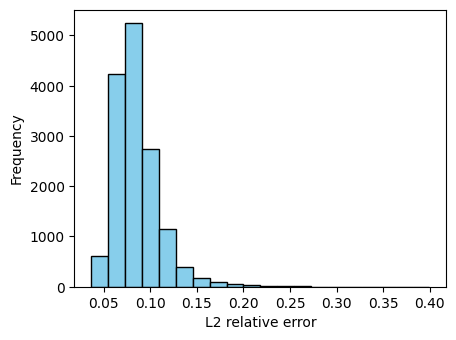

In [7]:
# overall performance on all test samples
error_s = cal_l2_error(s_pred_test, s_true_test)
sort_idx = np.argsort(error_s)
mean, std = np.mean(error_s), np.std(error_s)
print(f"Mean L2 error of test dataset: {mean}, std: {std}")
fig = plt.figure(figsize=(4.8, 3.6))
ax = plt.subplot(1, 1, 1)
_ = ax.hist(error_s[sort_idx[:-20]], bins=20,
            color="skyblue", edgecolor="black")
ax.set_xlabel("L2 relative error")
ax.set_ylabel("Frequency")

In [8]:
# performance on samples with cells; only the first 10000 samples have cells
sample_with_cells = np.where(sample_ids_test < 10000)[0]
error_s_with_cells = error_s[sample_with_cells]
sample_ids_test_with_cells = sample_ids_test[sample_with_cells]
s_pred_test_with_cells = [s_pred_test[i] for i in sample_with_cells]
s_true_test_with_cells = [s_true_test[i] for i in sample_with_cells]
verts_all_test_with_cells = [verts_all_test[i] for i in sample_with_cells]
pc_all_test_with_cells = [pc_all_test[i] for i in sample_with_cells]
sort_idx_with_cells = np.argsort(error_s_with_cells)


L2 realtive error of the best test sample: 0.04049507031838099


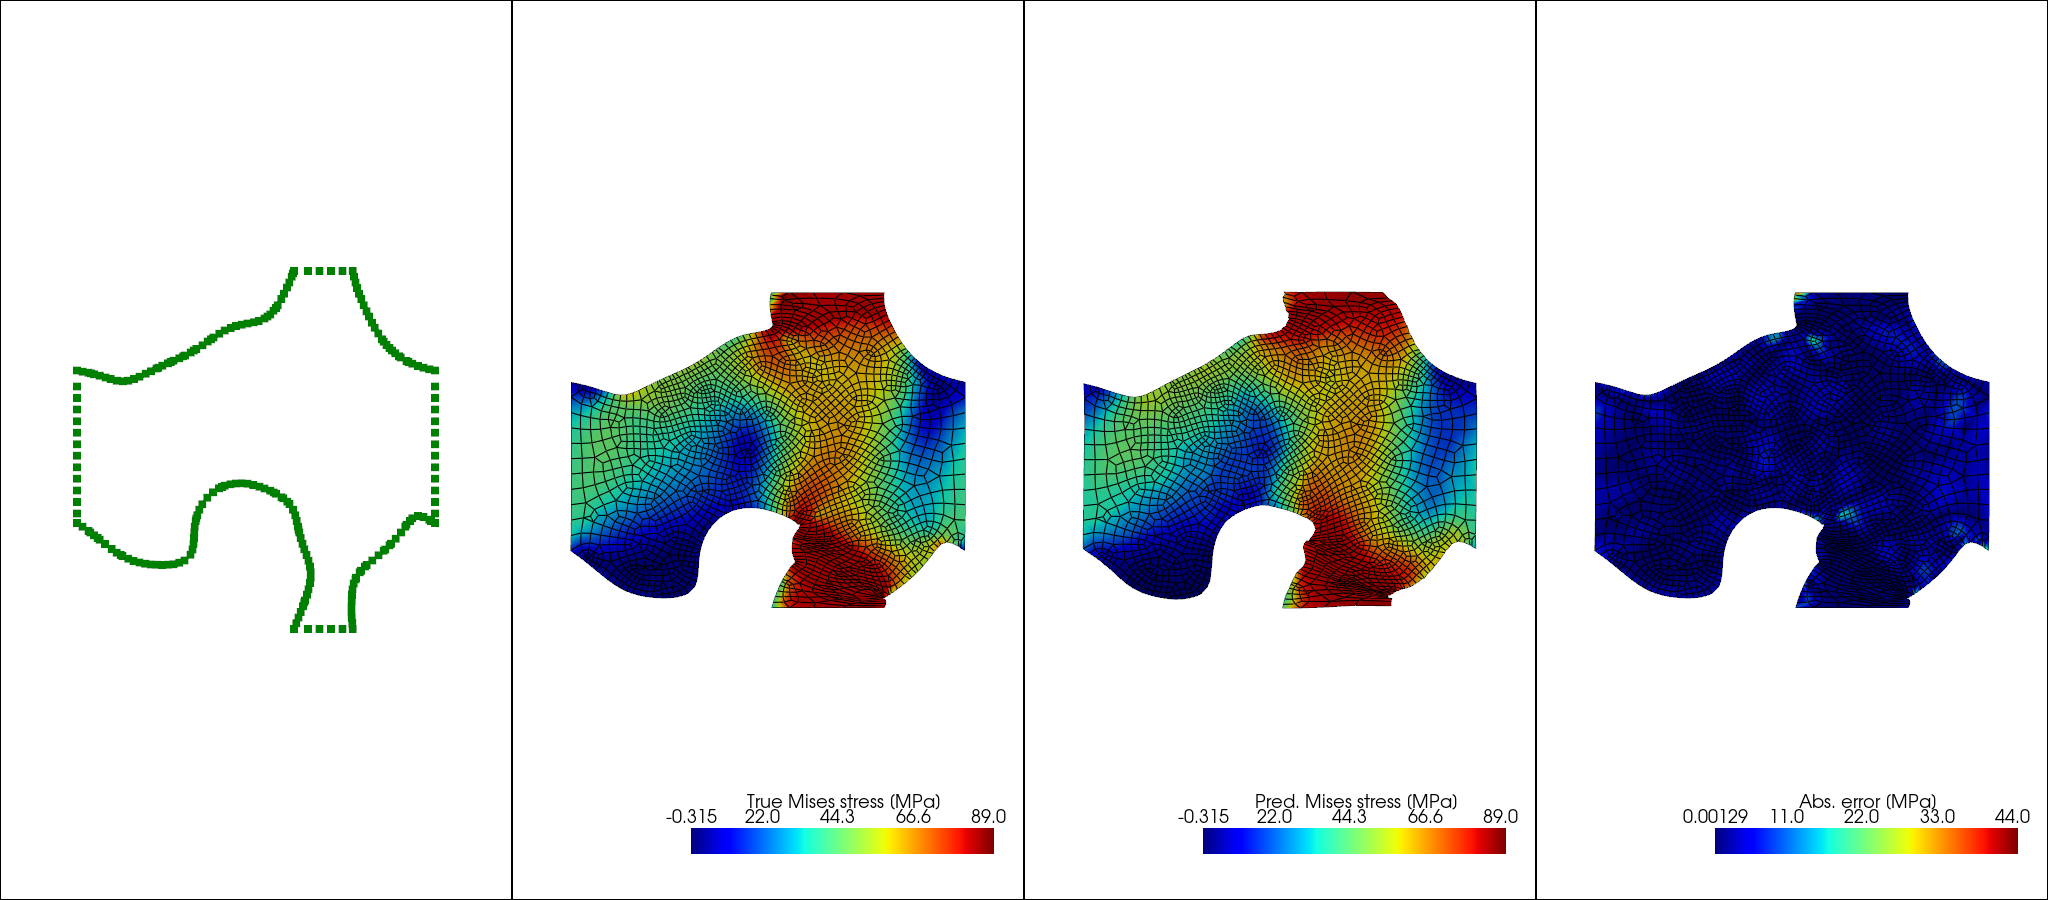

In [9]:
# plot the best sample
index = sort_idx_with_cells[0]
print(
    f"L2 realtive error of the best test sample: {error_s_with_cells[index]}")
cells_test = cells10k[sample_ids_test_with_cells[index]]
verts_test = verts_all_test_with_cells[index]
surface_pc_test = pc_all_test_with_cells[index]
mask = surface_pc_test != configs.PADDING_VALUE
pc_no_padded = surface_pc_test[mask].numpy().reshape(-1, 2)
True_s_test =s_true_test_with_cells[index]
Pred_s_test = s_pred_test_with_cells[index]
plot_results(pc_no_padded, True_s_test, Pred_s_test, cells_test,
             verts_test, cmap="jet", notebook=True, html_file=None, window_size=(2048, 900))


L2 realtive error of the 50 percentile test sample: 0.08460333943367004


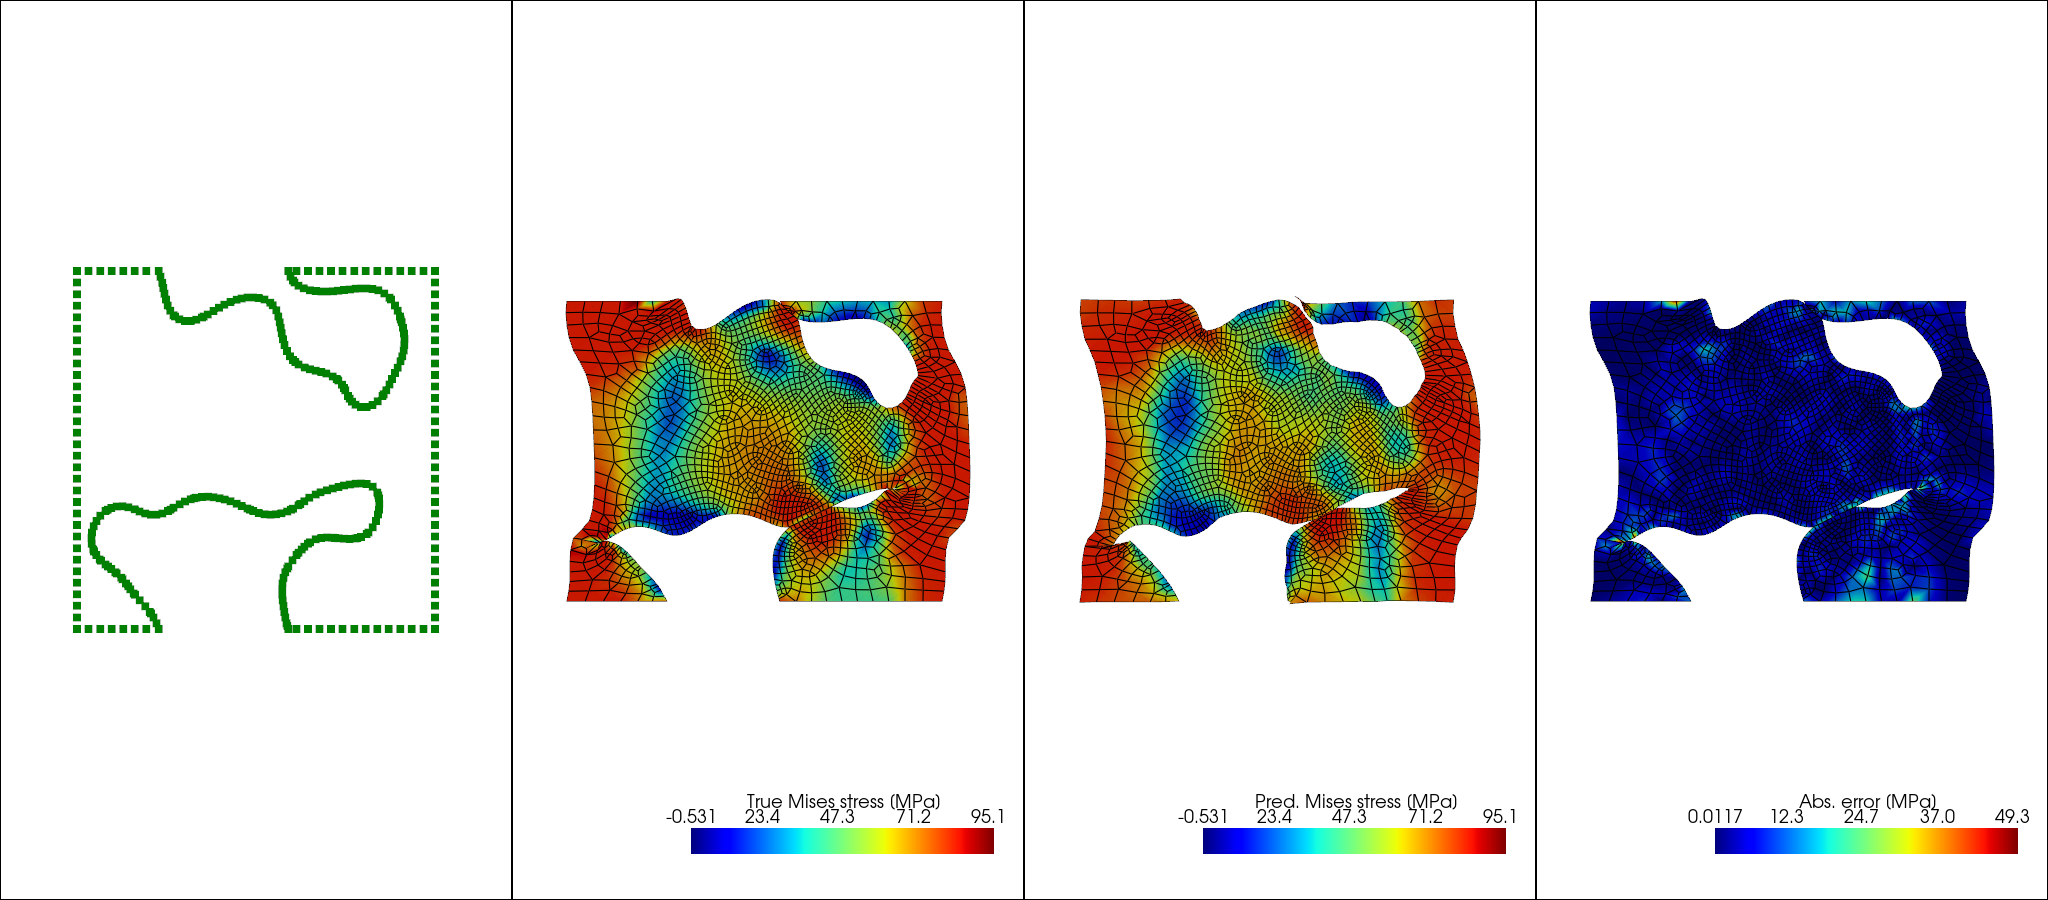

In [10]:
# plot the median sample
index = sort_idx_with_cells[int(len(sort_idx_with_cells)*0.5)-2]
print(
    f"L2 realtive error of the 50 percentile test sample: {error_s_with_cells[index]}")
cells_test = cells10k[sample_ids_test_with_cells[index]]
verts_test = verts_all_test_with_cells[index]
surface_pc_test = pc_all_test_with_cells[index]
surface_pc_test = pc_all_test_with_cells[index]
mask = surface_pc_test != configs.PADDING_VALUE
pc_no_padded = surface_pc_test[mask].numpy().reshape(-1, 2)
True_s_test =s_true_test_with_cells[index]
Pred_s_test = s_pred_test_with_cells[index]
plot_results(pc_no_padded, True_s_test, Pred_s_test, cells_test,
             verts_test, cmap="jet", notebook=True, html_file=None, window_size=(2048, 900))



L2 realtive error of the 95 percentile test sample: 0.14599071939786276


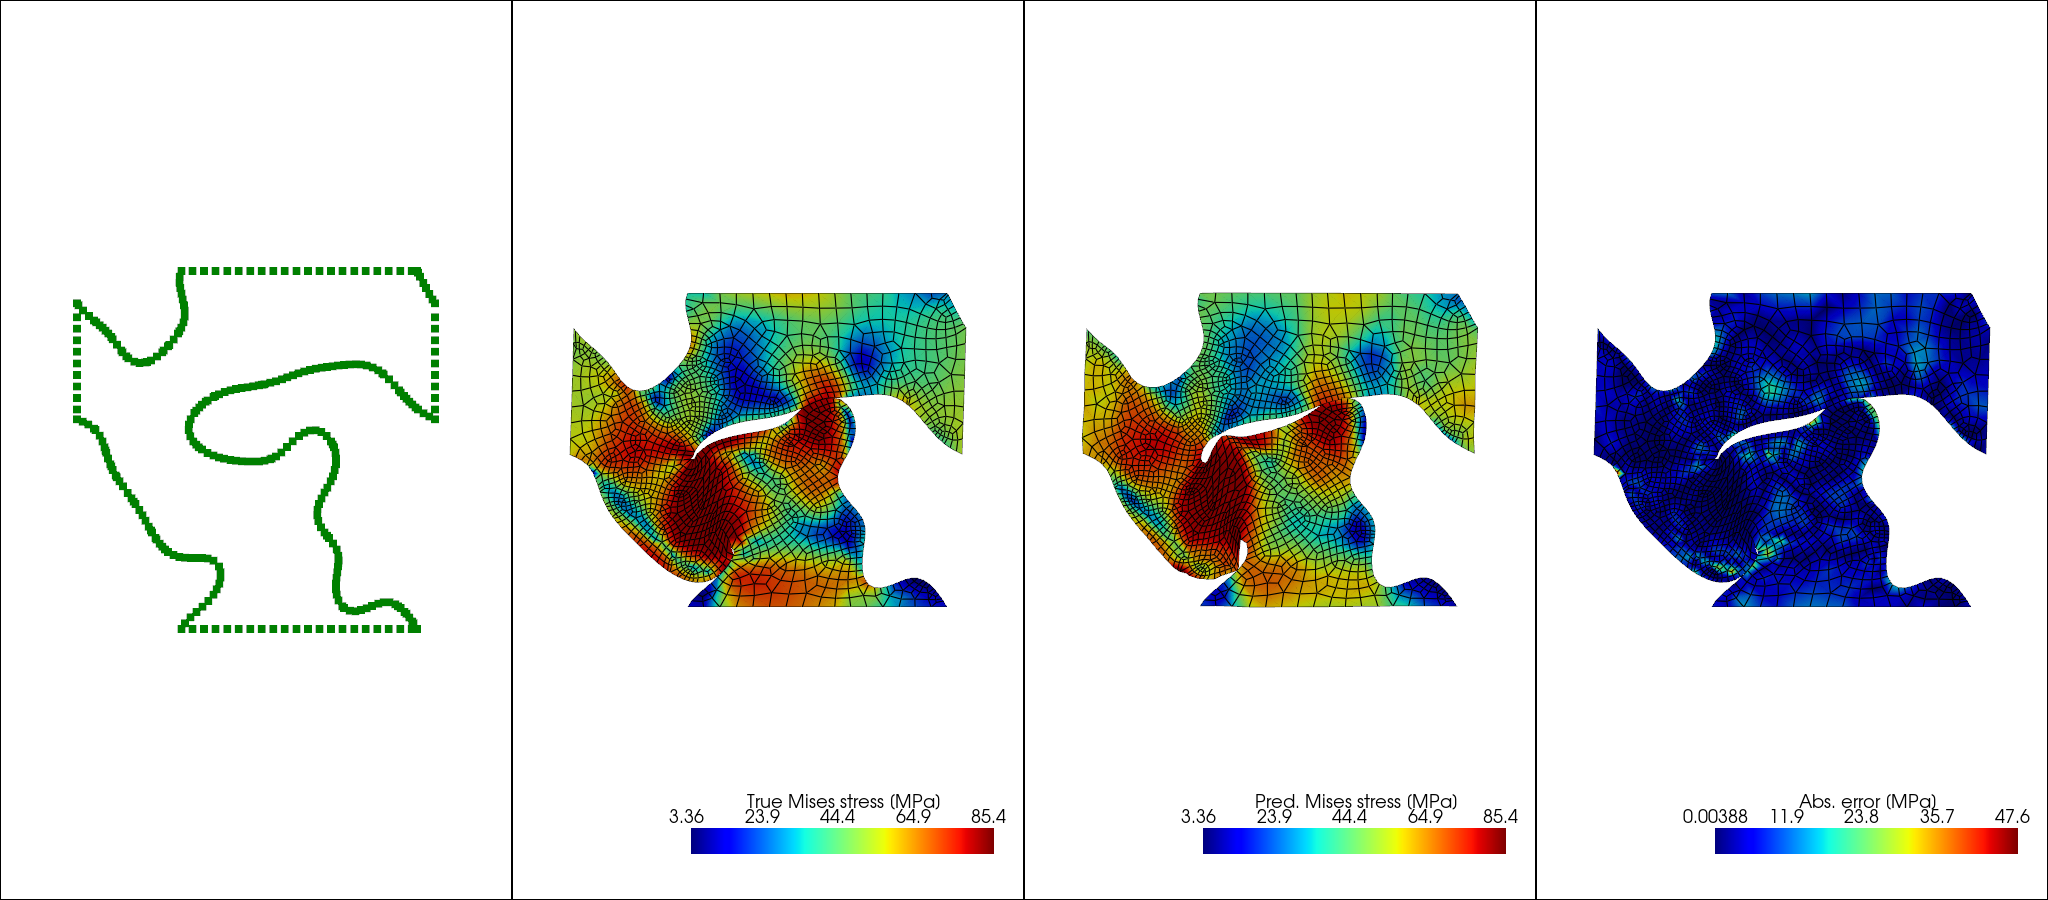

In [11]:
# plot the worst sample
index = sort_idx_with_cells[int(len(sort_idx_with_cells)*0.95)-4]
print(
    f"L2 realtive error of the 95 percentile test sample: {error_s_with_cells[index]}")
cells_test = cells10k[sample_ids_test_with_cells[index]]
verts_test = verts_all_test_with_cells[index]
surface_pc_test = pc_all_test_with_cells[index]
surface_pc_test = pc_all_test_with_cells[index]
mask = surface_pc_test != configs.PADDING_VALUE
pc_no_padded = surface_pc_test[mask].numpy().reshape(-1, 2)
True_s_test =s_true_test_with_cells[index]
Pred_s_test = s_pred_test_with_cells[index]
plot_results(pc_no_padded, True_s_test, Pred_s_test, cells_test,
             verts_test, cmap="jet", notebook=True, html_file=None, window_size=(2048, 900))



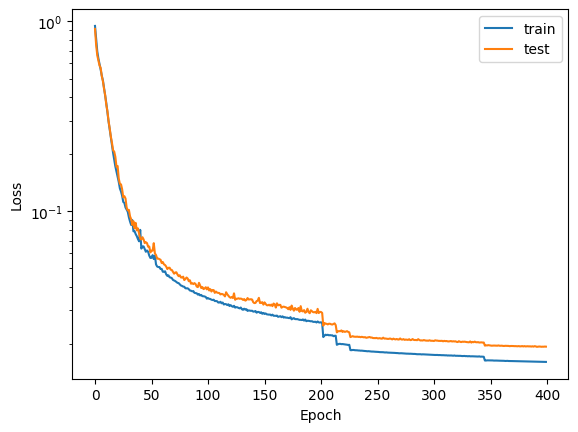

In [12]:
loss_file = filebase + "/logs.json"
with open(loss_file, 'r') as f:
    data = json.load(f)
plt.plot(data['loss'], label='train')
plt.plot(data['val_loss'], label='test')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


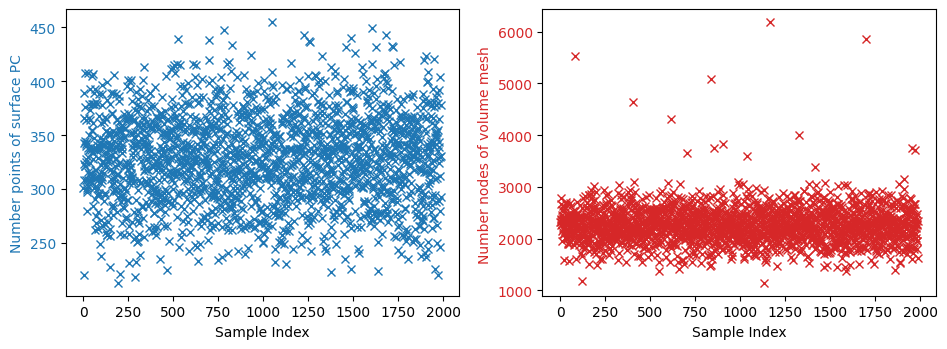

In [13]:
num_pc_point=[]
for x in pc_all_test_with_cells:
    mask = x != configs.PADDING_VALUE
    num_pc_point.append(len(x[mask])/2)
num_query_points = [len(x) for x in verts_all_test_with_cells]
fig = plt.figure(figsize=(4.8*2, 3.6))
ax1 = plt.subplot(1, 2, 1)
color = 'tab:blue'
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Number points of surface PC', color=color)
ax1.plot(num_pc_point, 'x', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = plt.subplot(1, 2, 2)
color = 'tab:red'
ax2.set_xlabel('Sample Index')
ax2.set_ylabel('Number nodes of volume mesh ', color=color)
ax2.plot(num_query_points, 'x', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()


In [14]:
index = sort_idx_with_cells[0]
print(
    f"L2 realtive error of the best test sample: {error_s_with_cells[index]}")
cells_test = cells10k[sample_ids_test_with_cells[index]]
verts_test = verts_all_test_with_cells[index]
surface_pc_test = pc_all_test_with_cells[index]
True_s_test = s_pred_test_with_cells[index]
Pred_s_test = s_true_test_with_cells[index]
pc_test = pc_all_test_with_cells[index]
# plot_results(True_s_test, Pred_s_test, cells_test,
#              verts_test, cmap="jet", notebook=True, html_file=None, window_size=(2048, 900))

xyt = torch.tensor(verts_test[None, :]).to(device)
mask = pc_test != configs.PADDING_VALUE
pc_no_padded = pc_test[mask].reshape(-1, 2)
pc = pc_no_padded[None, :].to(device)
pred_np_pad = ginot(xyt, pc)
pred_np_pad = su_inverse(pred_np_pad)
pred_np_pad = pred_np_pad.cpu().detach().numpy()

pc_reduced = pc_no_padded[::2]
pc = pc_reduced[None, :].to(device)
pred_np_reduced = ginot(xyt, pc)
pred_np_reduced = su_inverse(pred_np_reduced)
pred_np_reduced = pred_np_reduced.cpu().detach().numpy()

pc_padded_shuffled = pc_test[torch.randperm(pc_test.size(0))]
pc = pc_padded_shuffled[None, :].to(device)
pred_np_shuffled = ginot(xyt, pc)
pred_np_shuffled = su_inverse(pred_np_shuffled)
pred_np_shuffled = pred_np_shuffled.cpu().detach().numpy()

L2 realtive error of the best test sample: 0.04049507031838099


Number of points in Original: 220
Number of points in Reduced: 110
Number of points in Padded: 419
Number of points in Shuffle Padded: 419


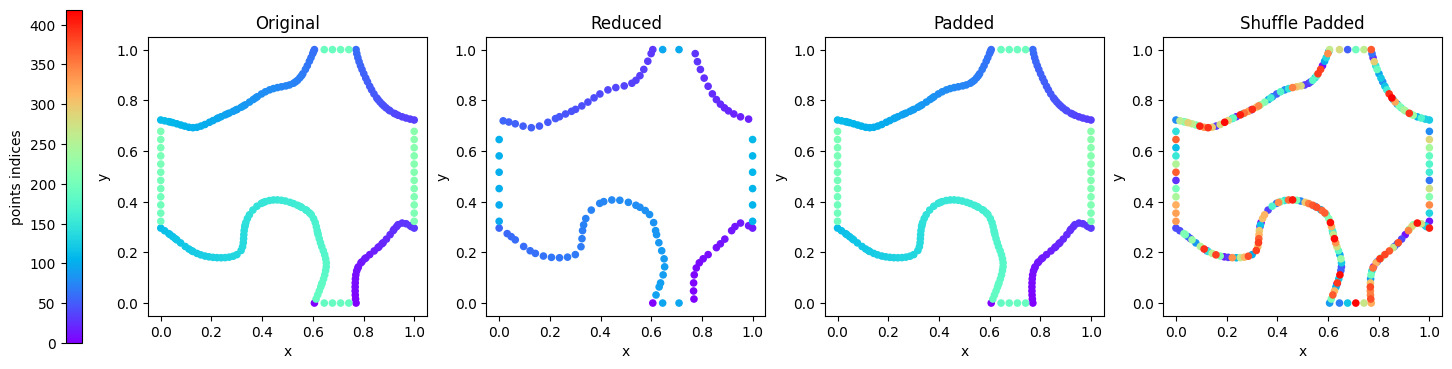

In [15]:
nc, nr = 4, 1
p_size = 20
fig, axes = plt.subplots(nr, nc, figsize=(
    nc*3.6, nr*3.6), constrained_layout=True)
pc_plots = [pc_no_padded.cpu().numpy(), pc_reduced.cpu().numpy(),
            pc_test.cpu().numpy(), pc_padded_shuffled.cpu().numpy()]
titles = ["Original", "Reduced", "Padded", "Shuffle Padded"]
vmin, vmax = 0, len(pc_plots[-1])
for i, pc in enumerate(pc_plots):
    print(f"Number of points in {titles[i]}: {len(pc)}")
    ax = axes[i]
    c = ax.scatter(pc[:, 0], pc[:, 1],
                   s=p_size, c=range(len(pc)),
                   cmap="rainbow", vmin=vmin, vmax=vmax)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(titles[i])
    if i == 2 or i == 3:
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)
    ax.set_aspect('equal')
fig.colorbar(c, ax=axes[0], location='left', label="points indices")


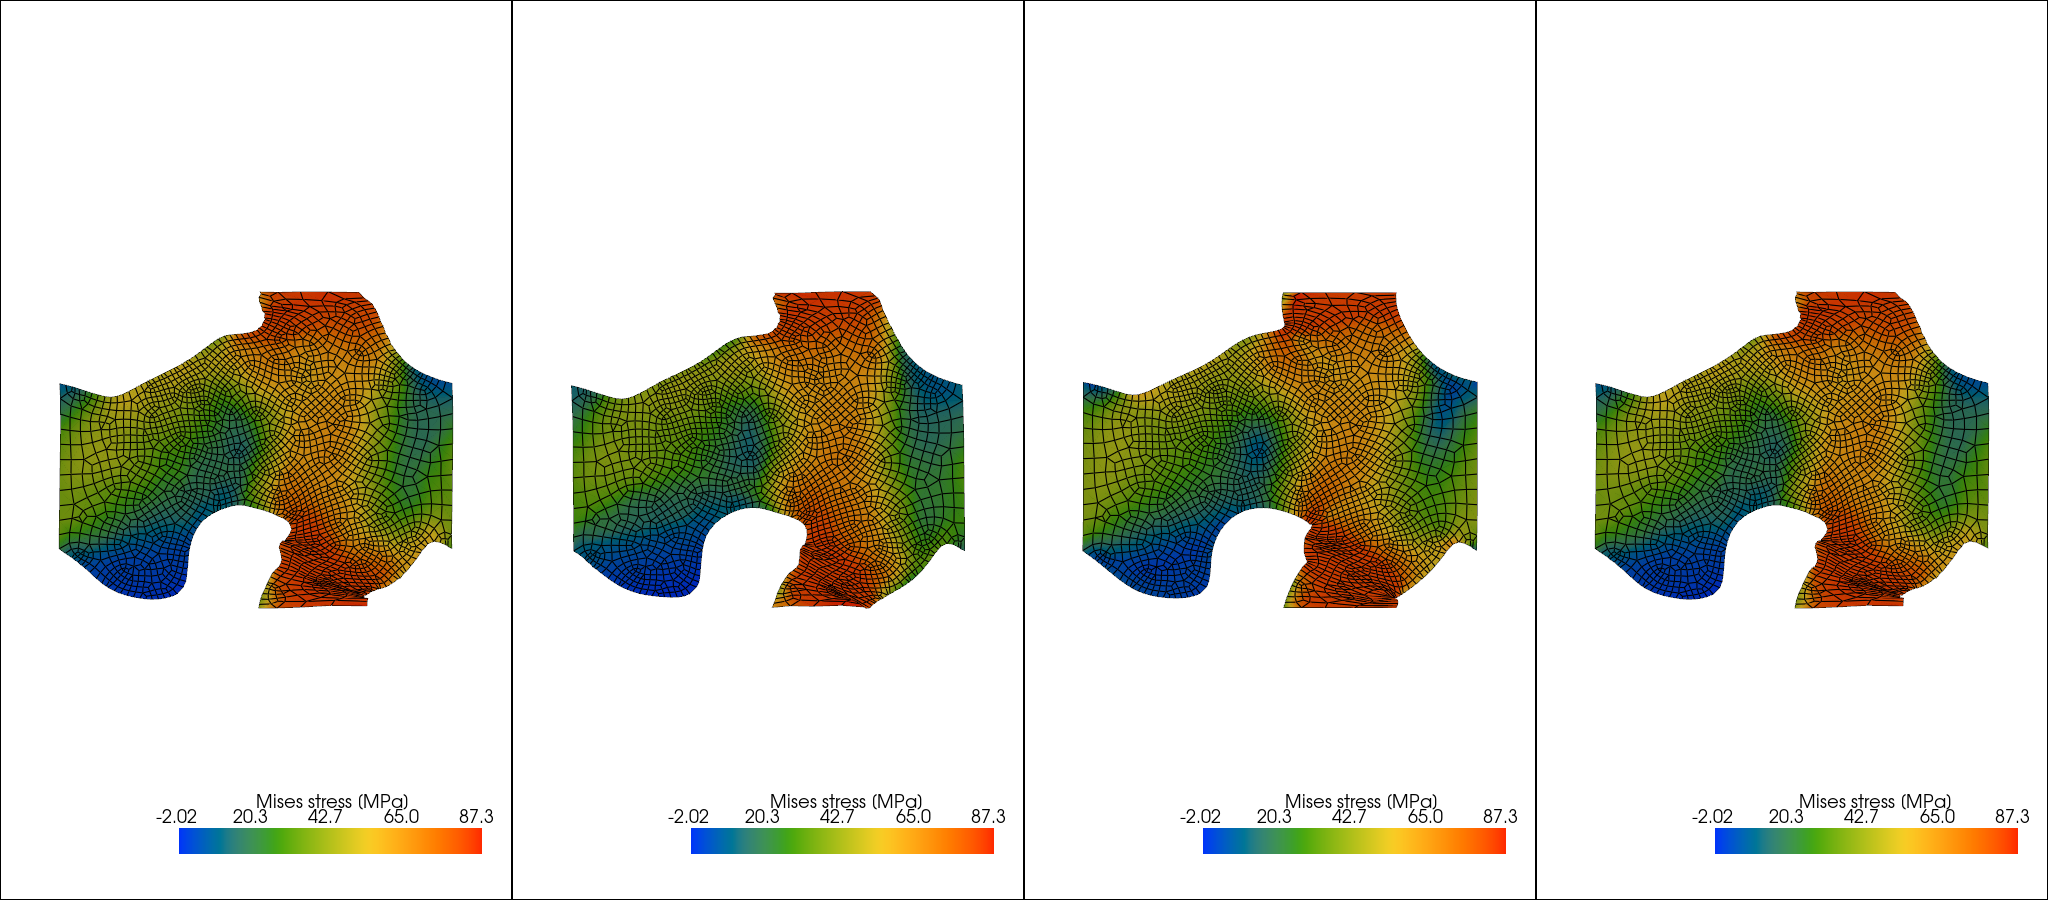

In [16]:
# check different pc has same prediction
cells, cell_types = get_pvstyle_cells(cells_test)
S_test = [pred_np_pad[0], pred_np_reduced[0],
          Pred_s_test, pred_np_shuffled[0]]
plotter = pv.Plotter(shape=(1, len(S_test)), notebook=True,
                     window_size=(2048, 900))
meshes = []
label = "Mises stress [MPa]"
labels = [" "*i+label for i in range(len(S_test))]
for i in range(len(S_test)):
    defomred_verts = verts_test + S_test[i][:, 1:3]
    defomred_verts = np.hstack(
        (defomred_verts, np.zeros((defomred_verts.shape[0], 1))))
    m = pv.UnstructuredGrid(cells, cell_types, defomred_verts)
    meshes.append(m)
    m.point_data[labels[i]] = S_test[i][:, 0]  # -S_test[0]
    plotter.subplot(0, i)
    plotter.add_mesh(m, scalars=labels[i],
                     show_edges=True, cmap="rainbow",
                     clim=[np.min(S_test[0][:, 0]), np.max(S_test[0][:, 0])])
    plotter.view_xy()
plotter.show()
